## Importing Data

In [ ]:
# -*- coding: utf-8 -*-
# Regression Example With Boston Dataset: Standardized and Wider
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import layers
from sklearn.utils import shuffle
import math

import pandas as pd
import seaborn as sns
import keras
import keras.utils
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

from mpl_toolkits import mplot3d
from cgi import test

dataset = pd.read_csv('aggregated_data.csv')


dataset = shuffle(dataset)
std_scaler = StandardScaler()


In [ ]:
def importData(data, scaler):

    train_dataset = data.sample(frac=0.8, random_state=9578)
    test_dataset = data.drop(train_dataset.index)

    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_labels = train_features.pop('Concentration')
    test_labels = test_features.pop('Concentration')

    train_features = scaler.fit_transform(train_features.to_numpy())
    dict = {
        'Time':train_features[:, 0], 
        'Current':train_features[:, 1], 
        'Spin Coating':train_features[:, 2] ,
        'Increaing PPM':train_features[:, 3], 
        'Temperature':train_features[:, 4], 
        'Repeat Sensor Use':train_features[:, 5], 
        'Days Elapsed':train_features[:, 6]
        }
    train_features = pd.DataFrame(dict)

    test_features = scaler.fit_transform(test_features.to_numpy())
    dict = {
        'Time':test_features[:, 0], 
        'Current':test_features[:, 1], 
        'Spin Coating':test_features[:, 2] ,
        'Increaing PPM':test_features[:, 3], 
        'Temperature':test_features[:, 4], 
        'Repeat Sensor Use':test_features[:, 5], 
        'Days Elapsed':test_features[:, 6]
        }
    test_features = pd.DataFrame(dict)

    #For later use
    data_labels = data.pop('Concentration')

    return data, data_labels, train_dataset, test_dataset, train_features, test_features, train_labels, test_labels, 
#sns.pairplot(train_dataset[['Time','Current', 'Spin Coating', 'Increasing PPM', 'Temperature', 'Repeat Sensor Use', 'Days Elapsed', 'Concentration']], diag_kind='kde')


# Neural Network Creation and Selection Process

### Functions: Build NN Model, Fit Model, K Cross Validation, Pearson Correlation Coefficient

In [ ]:
def build_model(n1, n2, train_feats):
  #Experiment with different models, thicknesses, layers, activation functions; Don't limit to only 10 nodes; Measure up to 64 nodes in 2 layers
  model = keras.Sequential([
    layers.Dense(n1, activation=tf.nn.relu, input_shape=[len(train_feats.keys())]),
    layers.Dense(n2, activation=tf.nn.relu),
    layers.Dense(n2, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

  return model

def model_history(features, labels, model, epo, batch, vbs):
  
    history = model.fit(
        features, labels,
        epochs=epo, batch_size=batch, validation_split=0.2, verbose=vbs #, callbacks=early_stop
    )

    hist = pd.DataFrame(history.history)
    
    return hist

def KCrossValidation(i, features, labels, num_val_samples, epochs, batch, verbose, n1, n2):

    print('processing fold #', i)
    val_data = features[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([features[:i * num_val_samples], features[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([labels[:i * num_val_samples], labels[(i + 1) * num_val_samples:]],     axis=0)

    model = build_model(n1, n2, features)

    history = model_history(partial_train_data, partial_train_targets, model, epochs, batch, verbose)

    test_loss, test_mae, test_mse = model.evaluate(val_data, val_targets, verbose=verbose)

    return model, history, test_loss, test_mae, test_mse

def Pearson(model, features, y_true, batch, verbose_):
    y_pred = model.predict(
        features,
        batch_size=None,
        verbose=verbose_,
        workers=3,
        use_multiprocessing=False,
    )

    tmp_numerator = 0
    tmp_denominator_real = 0
    tmp_denominator_pred = 0

    for i in range(len(y_pred)):
        tmp_numerator += (y_true[i] - sum(y_true)/len(y_true))* (y_pred[i] - sum(y_pred)/len(y_pred))

        tmp_denominator_real += (y_true[i] - sum(y_true)/len(y_true))**2
        tmp_denominator_pred += (y_pred[i] - sum(y_pred)/len(y_pred))**2

    R = tmp_numerator / (math.sqrt(tmp_denominator_pred) * math.sqrt(tmp_denominator_real))

    return R

## NEURAL NETWORK PARAMETERS

In [ ]:
all_features, data_labels, train_dataset, test_dataset, train_features, test_features, train_labels, test_labels,  = importData(dataset.copy(), std_scaler)
k_folds = 3 #4
num_val_samples = len(train_labels) // k_folds

n1_start = 10 #5
n2_start = 10 #5
sum_nodes = 23 #128

num_epochs = 400 #400
batch_size = 100 #100
verbose = 0
avg_val_scores = []
order_of_architecture = []

all_networks  = []
all_history  = []
mae_history = []

R_all = []


##### Plotting Functions

In [ ]:
def plot_loss(history):

  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  plt.show()

def correlation_plots(model, label, input_data, title, xlabel, ylabel):

  test_predictions = model.predict(input_data).flatten()
  plt.scatter(label,test_predictions)
  plt.plot(label, label, color='black', linestyle='solid')
  
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.axis('equal')
  plt.axis('square')
  plt.grid(True)
  plt.show()
  return test_predictions


def plotGraph(y_test, y_pred,regressorName):
    plt.scatter(range(len(y_pred)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    plt.show()
    return


#### Where the Magic Happens

In [ ]:
#(TAKEN FROM DEEP LEARNING WITH PYTHON BY MANNING)
for i in range(n1_start, sum_nodes):

    for j in range(n2_start, sum_nodes):
        if (i+j > sum_nodes):
            continue
        
        print("first hidden layer", j)
        print("second hidden layer", i)
        k_fold_test_scores = []
        k_models = []
        k_history = []

        k_mae_history = []
        R_tmp = []

        for fold in range(k_folds):
            model, history, test_loss, test_mae, test_mse = KCrossValidation(
                fold, 
                train_features, 
                train_labels, 
                num_val_samples, 
                num_epochs, 
                batch_size, 
                verbose, 
                j, 
                i)

            R_tmp.append(Pearson(model, train_features, train_labels.to_numpy(), batch_size, verbose )[0])
            k_fold_test_scores.append(test_mae)
            
            k_history.append(history)
            k_models.append(model)
            k_mae_history.append(history['val_mae'])


        R_all.append(sum(R_tmp)/len(R_tmp))
        avg_val_scores.append(sum(k_fold_test_scores)/len(k_fold_test_scores))
        all_history.append(k_history)
        all_networks.append(k_models)

        mae_history.append([ np.mean([x[i] for x in k_mae_history]) for i in range(num_epochs)])

        order_of_architecture.append([i, j])





#### Getting Pearson Coefficients

In [ ]:
# Find the model with the lowest error
lowest_mae_index = avg_val_scores.index(min(avg_val_scores))
optimal_NNs_mae = all_networks[lowest_mae_index]

highest_R_index = R_all.index(max(R_all))
optimal_NNs_R = all_networks[highest_R_index]

# Find the history of that model, and display it
for i in range(k_folds):
    x = all_history[lowest_mae_index][i]['val_mae']

Plotting Loss Transition

In [ ]:
from operator import index


def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

print(order_of_architecture[lowest_mae_index])
print(order_of_architecture[highest_R_index])

plt.plot(range(1, len(mae_history[lowest_mae_index][int(num_epochs/10):]) + 1), mae_history[lowest_mae_index][int(num_epochs/10):], label="Lowest MAE")
plt.plot(range(1, len(mae_history[highest_R_index][int(num_epochs/10):]) + 1), mae_history[highest_R_index][int(num_epochs/10):], label="Highest R")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

smooth_mae_history = smooth_curve(mae_history[lowest_mae_index][int(num_epochs/10):])
smooth_R_history = smooth_curve(mae_history[highest_R_index][int(num_epochs/10):])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history, label="Lowest MAE")
plt.plot(range(1, len(smooth_R_history) + 1), smooth_R_history, label="Highest R")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Isolating Parameters and Printing them Out

Scaling Data Set Function

In [ ]:
def scaleDataset(data):
    data = std_scaler.fit_transform(data.to_numpy())
    dict = {
        'Time':data[:, 0], 
        'Current':data[:, 1], 
        'Spin Coating':data[:, 2] ,
        'Increaing PPM':data[:, 3], 
        'Temperature':data[:, 4], 
        'Repeat Sensor Use':data[:, 5], 
        'Days Elapsed':data[:, 6]
        }
    return pd.DataFrame(dict)


## Functions for Isolating Parameters

In [ ]:
def isolateParam(optimal_NNs, data, parameter, start_index, end_index, NN_start, batch, verbose, mae_or_R):
    # Split the data labels with time
    param_index= []
    for i in range(start_index, end_index):
        param_index.append(np.where(data[parameter].to_numpy()  == i)[0])

    scaled_features = scaleDataset(all_features.copy())
    #The full features of the data points that use certain time values
    param_features = []
    param_labels = []

    for i in range(start_index, end_index):
        param_features.append(scaled_features.iloc[param_index[i]])
        #The stupid labels for each second
        param_labels.append(data_labels.to_numpy()[param_index[i]])


    mae = []
    R = []
    for i in range(NN_start, end_index):
        tmp_mae = []
        tmp_R = []
        
        for NN in optimal_NNs:
            test_loss, test_mae, test_mse = NN.evaluate(
                param_features[i], 
                param_labels[i], 
                batch_size=batch,  
                verbose=verbose
                )

            tmp_R.append(Pearson(NN, param_features[i], param_labels[i], batch, verbose)[0])
            
            tmp_mae.append(test_mae)
            
            _predictions = correlation_plots(
                NN, 
                param_labels[i], 
                param_features[i], 
                "Testing Correlation Plot for "+  parameter + ": " + str(i) + " " + mae_or_R, 
                "Actual", 
                "Predicted"
                )

            
        R.append(tmp_R)
        mae.append(tmp_mae)

    average_R = []
    average_mae = []
    for i in range(len(mae)):
        average_R.append(sum(R[i])/len(R[i]))
        average_mae.append(sum(mae[i])/len(mae[i]))


    return average_R, average_mae


In [ ]:
def IsolateBinaryTime(optimal_NNs, data, parameter, start_time, batch, vbs, mae_or_R):
    # Splitting Spin Coating, then seperating by time

    ss_1 = np.where(data[parameter].to_numpy()  ==  1)[0]
    ss_0 = np.where(data[parameter].to_numpy()  ==  0)[0]

    times_index = []
    times_0 = []

    shared_time_1 = []
    shared_time_0 = []

    for i in range(0, 51):
        times_index.append(np.where(data['Time'].to_numpy()  == i)[0].tolist())

        time_1_tmp = []
        time_0_tmp = []
        
        for index_sc in ss_1:
            if index_sc in times_index[i]:
                time_1_tmp.append(index_sc)
        for index_sc in ss_0:
            if index_sc in times_index[i]:
                time_0_tmp.append(index_sc)
                
        shared_time_1.append(time_1_tmp)
        shared_time_0.append(time_0_tmp)

    scaled_features = scaleDataset(all_features.copy())

    shared_features = []
    shared_labels = []

    for i in range(0, 51):
        shared_features.append([
            scaled_features.iloc[shared_time_0[i]], 
            scaled_features.iloc[shared_time_1[i]]
            ])
            
        shared_labels.append([
            data_labels.to_numpy()[shared_time_0[i]], 
            data_labels.to_numpy()[shared_time_1[i]]
            ])
    

    shared_mae = []
    shared_R = []
    for i in range(start_time, 51):
        sc_tmp_mae = []
        sc_tmp_R = []

        for j in range(0, 2):
            tmp_mae = []
            tmp_R = []
            #print("TIME = ", i, "S", "SPINCOATED = ", j)

            for NN in optimal_NNs:
                test_loss, test_mae, test_mse = NN.evaluate(
                    shared_features[i][j], 
                    shared_labels[i][j],
                    batch_size=batch,  
                    verbose=vbs
                    )
            
                tmp_R.append(Pearson(NN, shared_features[i][j], shared_labels[i][j], batch, vbs)[0])
                tmp_mae.append(test_mae)

                    
            shared_predictions = correlation_plots(
                NN, shared_labels[i][j], 
                shared_features[i][j].to_numpy(),  
                "Testing Correlation Plot for Shared " + str(j) + " at time: " + str(i) + " " + mae_or_R, 
                "Actual", "Predicted"
                )
            


            #plotGraph(shared_labels[i][j], shared_predictions, "Shared Plot")

            sc_tmp_mae.append(tmp_mae)
            sc_tmp_R.append(tmp_R)

        shared_mae.append(sc_tmp_mae)
        shared_R.append(sc_tmp_R)


    averages_R = []
    averages_mae = []
    for i in shared_mae:
        averages_mae.append([sum(i[0])/len(i[0]), sum(i[1])/len(i[1])])

    for i in shared_R:
        averages_R.append([sum(i[0])/len(i[0]), sum(i[1])/len(i[1])])


    return averages_R, averages_mae

#### Isolating Spin Coating

In [ ]:
R_of_sc_mae, mae_of_sc_mae = isolateParam(optimal_NNs_mae, dataset, 'Spin Coating', 0, 2, 0, 10, 1, "MAE")
R_of_sc_R, mae_of_sc_R = isolateParam(optimal_NNs_R, dataset, 'Spin Coating', 0, 2, 0, 10, 1, "R")


#### Isolating Time

In [ ]:
NN_start_time = 20
R_time_mae, mae_averages_time_mae = isolateParam(optimal_NNs_mae, dataset, 'Time', 0, 51, NN_start_time, 100, 1, "MAE")
R_time_R, mae_averages_time_R = isolateParam(optimal_NNs_R, dataset, 'Time', 0, 51, NN_start_time, 100, 1, "R")

In [ ]:
plt.plot(range(NN_start_time, len(mae_averages_time_mae) +NN_start_time), mae_averages_time_mae, label="Time Isolating; Optimal MAE Network")
plt.plot(range(NN_start_time, len(mae_averages_time_R) +NN_start_time), mae_averages_time_R, label="Time Isolating; Optimal R Network")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Mean Absolute Error')
plt.show()

plt.plot(range(NN_start_time, len(R_time_mae) +NN_start_time), R_time_mae, label="Time Isolating; Optimal MAE Network")
plt.plot(range(NN_start_time, len(R_time_R) +NN_start_time), R_time_R, label="Time Isolating; Optimal R Network")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('R')
plt.show()


#### Isolating Spin Coating and Time

In [ ]:
verbose_isolate = 0
NN_start_sc_t = 15
R_of_sct_mae, mae_of_sct_mae = IsolateBinaryTime(optimal_NNs_mae,dataset, 'Spin Coating', NN_start_sc_t, 10, verbose_isolate, "MAE")
R_of_sct_R, mae_of_sct_R = IsolateBinaryTime(optimal_NNs_R, dataset, 'Spin Coating', NN_start_sc_t, 10, verbose_isolate, "R")


In [ ]:
R_of_mins_sct_mae_1 = [R_of_sct_mae[i][1] for i in range(len(R_of_sct_mae))]
R_of_mins_sct_mae_0 = [R_of_sct_mae[i][0] for i in range(len(R_of_sct_mae))]

mae_of_averages_sct_mae_1 = [mae_of_sct_mae[i][1] for i in range(len(mae_of_sct_mae))]
mae_of_averages_sct_mae_0 = [mae_of_sct_mae[i][0] for i in range(len(mae_of_sct_mae))]

R_of_mins_sct_R_1 = [R_of_sct_R[i][1] for i in range(len(R_of_sct_R))]
R_of_mins_sct_R_0 = [R_of_sct_R[i][0] for i in range(len(R_of_sct_R))]

mae_of_averages_sct_R_1 = [mae_of_sct_R[i][1] for i in range(len(mae_of_sct_R))]
mae_of_averages_sct_R_0 = [mae_of_sct_R[i][0] for i in range(len(mae_of_sct_R))]


plt.plot(range(NN_start_sc_t, len(mae_of_averages_sct_mae_1) +NN_start_sc_t), mae_of_averages_sct_mae_1, label="Spin Coating; Optimal MAE Network")
plt.plot(range(NN_start_sc_t, len(mae_of_averages_sct_mae_0) +NN_start_sc_t), mae_of_averages_sct_mae_0, label="No Spin Coating; Optimal MAE Network")

plt.plot(range(NN_start_sc_t, len(mae_of_averages_sct_R_1) +NN_start_sc_t), mae_of_averages_sct_R_1, label="Spin Coating; Optimal R Network")
plt.plot(range(NN_start_sc_t, len(mae_of_averages_sct_R_0) +NN_start_sc_t), mae_of_averages_sct_R_0, label="No Spin Coating; Optimal R Network")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Mean Absolute Error')
plt.show()

plt.plot(range(NN_start_sc_t, len(R_of_mins_sct_mae_1) +NN_start_sc_t), R_of_mins_sct_mae_1, label="Spin Coating; Optimal MAE Network")
plt.plot(range(NN_start_sc_t, len(R_of_mins_sct_mae_0) +NN_start_sc_t), R_of_mins_sct_mae_0, label="No Spin Coating; Optimal MAE Network")

plt.plot(range(NN_start_sc_t, len(R_of_mins_sct_R_1) +NN_start_sc_t), R_of_mins_sct_R_1, label="Spin Coating; Optimal R Network")
plt.plot(range(NN_start_sc_t, len(R_of_mins_sct_R_0) +NN_start_sc_t), R_of_mins_sct_R_0, label="No Spin Coating; Optimal R Network")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('R')
plt.show()



#### Isolating Increasing PPM and Time

In [ ]:
verbose_isolate = 1
start_t_increasing = 15
R_of_increasing_mae, mae_of_increasing_mae = IsolateBinaryTime(optimal_NNs_mae, dataset, 'Increasing PPM', start_t_increasing, 10, verbose_isolate, "MAE")
R_of_increasing_R, mae_of_increasing_R = IsolateBinaryTime(optimal_NNs_R, dataset, 'Increasing PPM', start_t_increasing, 10, verbose_isolate, "R")


In [ ]:
R_of_increasing_mae_1 = [R_of_increasing_mae[i][1] for i in range(len(R_of_increasing_mae))]
R_of_increasing_mae_0 = [R_of_increasing_mae[i][0] for i in range(len(R_of_increasing_mae))]

mae_of_increasing_mae_1 = [mae_of_increasing_mae[i][1] for i in range(len(mae_of_increasing_mae))]
mae_of_increasing_mae_0 = [mae_of_increasing_mae[i][0] for i in range(len(mae_of_increasing_mae))]

R_of_increasing_R_1 = [R_of_increasing_R[i][1] for i in range(len(R_of_increasing_R))]
R_of_increasing_R_0 = [R_of_increasing_R[i][0] for i in range(len(R_of_increasing_R))]

mae_of_increasing_R_1 = [mae_of_increasing_R[i][1] for i in range(len(mae_of_increasing_R))]
mae_of_increasing_R_0 = [mae_of_increasing_R[i][0] for i in range(len(mae_of_increasing_R))]


plt.plot(range(NN_start_sc_t, len(mae_of_increasing_mae_1) +NN_start_sc_t), mae_of_increasing_mae_1, label="Increasing PPM; Optimal MAE Network")
plt.plot(range(NN_start_sc_t, len(mae_of_increasing_mae_0) +NN_start_sc_t), mae_of_increasing_mae_0, label=" Decreasing PPM; Optimal MAE Network")

plt.plot(range(NN_start_sc_t, len(mae_of_increasing_R_1) +NN_start_sc_t), mae_of_increasing_R_1, label="Increasing PPM; Optimal R Network")
plt.plot(range(NN_start_sc_t, len(mae_of_increasing_R_0) +NN_start_sc_t), mae_of_increasing_R_0, label="Decreasing PPM; Optimal R Network")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Mean Absolute Error')
plt.show()

plt.plot(range(NN_start_sc_t, len(R_of_increasing_mae_1) +NN_start_sc_t), R_of_increasing_mae_1, label="Increasing PPM; Optimal MAE Network")
plt.plot(range(NN_start_sc_t, len(R_of_increasing_mae_0) +NN_start_sc_t), R_of_increasing_mae_0, label="Decreasing PPM; Optimal MAE Network")

plt.plot(range(NN_start_sc_t, len(R_of_increasing_R_1) +NN_start_sc_t), R_of_increasing_R_1, label="Increasing PPM; Optimal R Network")
plt.plot(range(NN_start_sc_t, len(R_of_increasing_R_0) +NN_start_sc_t), R_of_increasing_R_0, label="Decreasing PPM; Optimal R Network")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('R')
plt.show()



#### Repeat Sensor Use

In [ ]:
def repeatSensor(optimal_NNs, data, parameter1, parameter2, start_index, end_index, start_time, batch, vbs, mae_or_R):
#def isolateParam(optimal_NNs, data, parameter, start_index, end_index, NN_start, batch, verbose, mae_or_R):

    # Split the data labels with RSU
    repeat_index= []
    for i in range(start_index, end_index):
    #for i in range(1, 4):

        repeat_index.append(np.where(data[parameter1].to_numpy()  == i+1)[0])
        #repeat_index.append(np.where(data['Repeat Sensor Use'].to_numpy()  == i)[0])

    shared_tr_1 = []
    shared_tr_2 = []
    shared_tr_3 = []

    times_index = []
    for i in range(0, 51):
        times_index.append(np.where(data[parameter2].to_numpy()  == i)[0].tolist())
        #times_index.append(np.where(data['Time'].to_numpy()  == i)[0].tolist())

        tr_1_tmp = []
        tr_2_tmp = []
        tr_3_tmp = []

        for j in range(len(repeat_index)):
    
            for index_123 in repeat_index[j]:

                if index_123 in times_index[i] and j == 0:
                    tr_1_tmp.append(index_123)
                elif index_123 in times_index[i] and j == 1:
                    tr_2_tmp.append(index_123)
                elif index_123 in times_index[i] and j == 2:
                    tr_3_tmp.append(index_123)

    #            time_0_tmp.append(index_sc)
            

        shared_tr_1.append(tr_1_tmp)
        shared_tr_2.append(tr_2_tmp)
        shared_tr_3.append(tr_3_tmp)

    scaled_features = scaleDataset(all_features.copy())
    #The full features of the data points that use certain time values
    tr_features = []
    tr_labels = []


    for i in range(0, 51):
        tr_features.append([
            scaled_features.iloc[shared_tr_1[i]], 
            scaled_features.iloc[shared_tr_2[i]], 
            scaled_features.iloc[shared_tr_3[i]]
            ])

        tr_labels.append([
            data_labels.to_numpy()[shared_tr_1[i]], 
            data_labels.to_numpy()[shared_tr_2[i]], 
            data_labels.to_numpy()[shared_tr_3[i]]
            ])

    tr_mae = []
    tr_R = []
    for i in range(start_time, 51):
        tr_tmp_mae = []
        tr_tmp_R = []

        for j in range(start_index, end_index):

            tmp_mae = []
            tmp_R = []

            for NN in optimal_NNs:
                test_loss, test_mae, test_mse = NN.evaluate(tr_features[i][j], tr_labels[i][j], batch_size=batch,  verbose=vbs)
                
                tmp_R.append(Pearson(NN, tr_features[i][j], tr_labels[i][j], batch, vbs)[0])
                tmp_mae.append(test_mae)

                #repeat_predictions = correlation_plots(NN, repeat_labels[i], repeat_features[i], "Testing Correlation Plot for RSU " + str(i), "Actual", "Predicted")
                #plotGraph(RSU_labels[i], RSU_predictions, "RSU Plot")

            tr_tmp_mae.append(tmp_mae)
            tr_tmp_R.append(tmp_R)

        tr_mae.append(tr_tmp_mae)
        tr_R.append(tr_tmp_R)


    averages_mae = []
    averages_R = []

    for i in tr_mae:
        averages_mae.append([sum(i[0])/len(i[0]), sum(i[1])/len(i[1]), sum(i[2])/len(i[2])])

    for i in tr_R:
        averages_R.append([sum(i[0])/len(i[0]), sum(i[1])/len(i[1]), sum(i[2])/len(i[2])])


    return averages_R, averages_mae

In [56]:
batch_repeat = 100
verbose_repeat = 0
start_index= 0
end_index = 3
start_time = 20


R_of_tr_mae, mae_of_tr_mae = repeatSensor(
    optimal_NNs_mae, 
    dataset, 
    'Repeat Sensor Use', 
    'Time',
    start_index, 
    end_index, 
    start_time, 
    batch_repeat, 
    verbose_repeat, 
    "MAE"
    )

R_of_tr_R, mae_of_tr_R = repeatSensor(
    optimal_NNs_R, 
    dataset, 
    'Repeat Sensor Use', 
    'Time',
    start_index, 
    end_index, 
    start_time, 
    batch_repeat, 
    verbose_repeat, 
    "R"
    )



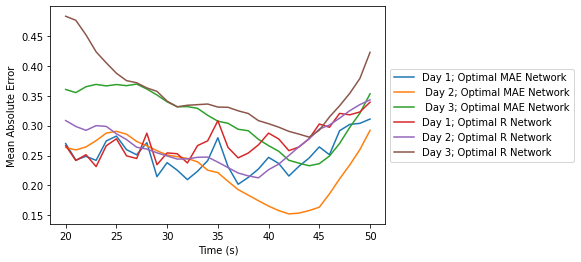

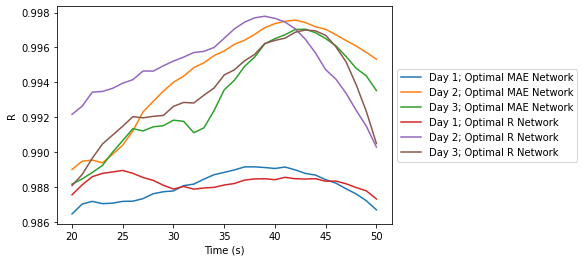

In [57]:
R_of_tr_mae_0 = [R_of_tr_mae[i][0] for i in range(len(R_of_tr_mae))]
R_of_tr_mae_1 = [R_of_tr_mae[i][1] for i in range(len(R_of_tr_mae))]
R_of_tr_mae_2 = [R_of_tr_mae[i][2] for i in range(len(R_of_tr_mae))]

mae_of_tr_mae_0 = [mae_of_tr_mae[i][0] for i in range(len(mae_of_tr_mae))]
mae_of_tr_mae_1 = [mae_of_tr_mae[i][1] for i in range(len(mae_of_tr_mae))]
mae_of_tr_mae_2 = [mae_of_tr_mae[i][2] for i in range(len(mae_of_tr_mae))]

R_of_tr_R_0 = [R_of_tr_R[i][0] for i in range(len(R_of_tr_R))]
R_of_tr_R_1 = [R_of_tr_R[i][1] for i in range(len(R_of_tr_R))]
R_of_tr_R_2 = [R_of_tr_R[i][2] for i in range(len(R_of_tr_R))]

mae_of_tr_R_0 = [mae_of_tr_R[i][0] for i in range(len(mae_of_tr_R))]
mae_of_tr_R_1 = [mae_of_tr_R[i][1] for i in range(len(mae_of_tr_R))]
mae_of_tr_R_2 = [mae_of_tr_R[i][2] for i in range(len(mae_of_tr_R))]


plt.plot(range(start_time, len(mae_of_tr_mae_0) +start_time), mae_of_tr_mae_0, label="Day 1; Optimal MAE Network")
plt.plot(range(start_time, len(mae_of_tr_mae_1) +start_time), mae_of_tr_mae_1, label=" Day 2; Optimal MAE Network")
plt.plot(range(start_time, len(mae_of_tr_mae_2) +start_time), mae_of_tr_mae_2, label=" Day 3; Optimal MAE Network")

plt.plot(range(start_time, len(mae_of_tr_R_0) +start_time), mae_of_tr_R_0, label="Day 1; Optimal R Network")
plt.plot(range(start_time, len(mae_of_tr_R_1) +start_time), mae_of_tr_R_1, label="Day 2; Optimal R Network")
plt.plot(range(start_time, len(mae_of_tr_R_2) +start_time), mae_of_tr_R_2, label="Day 3; Optimal R Network")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('Mean Absolute Error')
plt.show()

plt.plot(range(start_time, len(R_of_tr_mae_0) +start_time), R_of_tr_mae_0, label="Day 1; Optimal MAE Network")
plt.plot(range(start_time, len(R_of_tr_mae_1) +start_time), R_of_tr_mae_1, label="Day 2; Optimal MAE Network")
plt.plot(range(start_time, len(R_of_tr_mae_2) +start_time), R_of_tr_mae_2, label="Day 3; Optimal MAE Network")

plt.plot(range(start_time, len(R_of_tr_R_0) +start_time), R_of_tr_R_0, label="Day 1; Optimal R Network")
plt.plot(range(start_time, len(R_of_tr_R_1) +start_time), R_of_tr_R_1, label="Day 2; Optimal R Network")
plt.plot(range(start_time, len(R_of_tr_R_2) +start_time), R_of_tr_R_2, label="Day 3; Optimal R Network")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (s)')
plt.ylabel('R')
plt.show()



# Printing to CSV

In [58]:
import os
filepath = r".\\"
local_download_path = os.path.expanduser(filepath)

In [59]:
dict_sc = pd.DataFrame({
    "Optimal MAE NN: R"    : R_of_sc_mae,
    "Optimal R NN: R"      : R_of_sc_R,
    "Optimal MAE NN: MAE"  : mae_of_sc_mae,
    "Optimal R NN: MAE"  : mae_of_sc_R
    })
display(dict_sc)
dict_sc.to_csv('spin_coating.csv', index=False)

,Optimal MAE NN: R,Optimal R NN: R,Optimal MAE NN: MAE,Optimal R NN: MAE
0,0.977962,0.981558,0.297013,0.308129
1,0.973200,0.974332,0.371421,0.374897


In [60]:
dict_time = pd.DataFrame({
    "Optimal MAE NN: R"    : R_time_mae, 
    "Optimal R NN: R"      : R_time_R,
    "Optimal MAE NN: MAE"  : mae_averages_time_mae, 
    "Optimal R NN: MAE"    : mae_averages_time_R
    })
display(dict_time)
dict_sc.to_csv('time.csv', index=False)


,Optimal MAE NN: R,Optimal R NN: R,Optimal MAE NN: MAE,Optimal R NN: MAE
0,0.986757,0.987454,0.278813,0.292385
1,0.987273,0.988003,0.257302,0.270290
2,0.987387,0.988560,0.258417,0.256203
3,0.987245,0.988864,0.248042,0.250303
4,0.987331,0.989030,0.264923,0.258966
5,0.987472,0.989210,0.272013,0.269738
6,0.987547,0.989147,0.267755,0.265135
7,0.987730,0.988971,0.257293,0.259730
8,0.988039,0.988843,0.259579,0.270100
9,0.988211,0.988617,0.242488,0.253804


In [61]:
dict_sc_time = pd.DataFrame({
    "SC: 0;  Optimal MAE NN: R"    : [R_of_sct_mae[i][0] for i in range(len(R_of_sct_mae))], 
    "SC: 0;  Optimal R NN: R"      : [R_of_sct_R[i][0] for i in range(len(R_of_sct_R))],

    "SC: 1;  Optimal MAE NN: R"    : [R_of_sct_mae[i][1] for i in range(len(R_of_sct_mae))],     
    "SC: 1;  Optimal R NN: R"      : [R_of_sct_R[i][1] for i in range(len(R_of_sct_R))],

    "SC: 0;  Optimal MAE NN: MAE"  : [mae_of_sct_mae[i][0] for i in range(len(mae_of_sct_mae))], 
    "SC: 0;  Optimal R NN: MAE"    : [mae_of_sct_R[i][0] for i in range(len(mae_of_sct_R))],

    "SC: 1;  Optimal MAE NN: MAE"  : [mae_of_sct_mae[i][1] for i in range(len(mae_of_sct_mae))], 
    "SC: 1; Optimal R NN: MAE"    : [mae_of_sct_R[i][1] for i in range(len(mae_of_sct_R))]
    })

display(dict_sc_time)
dict_sc.to_csv('sc_time.csv', index=False)


,SC: 0; Optimal MAE NN: R,SC: 0; Optimal R NN: R,SC: 1; Optimal MAE NN: R,SC: 1; Optimal R NN: R,SC: 0; Optimal MAE NN: MAE,SC: 0; Optimal R NN: MAE,SC: 1; Optimal MAE NN: MAE,SC: 1; Optimal R NN: MAE
0,0.985976,0.988876,0.983206,0.982622,0.269338,0.243156,0.341311,0.344808
1,0.987130,0.989881,0.983630,0.983694,0.289662,0.253307,0.330821,0.339379
2,0.987545,0.990232,0.983784,0.984593,0.267698,0.255256,0.326524,0.330368
3,0.988290,0.990098,0.984210,0.985348,0.247583,0.251638,0.315280,0.318325
4,0.989043,0.990051,0.984617,0.985998,0.248820,0.247932,0.305066,0.304629
5,0.989902,0.989947,0.984982,0.986403,0.235602,0.254991,0.305949,0.300175
6,0.990657,0.990452,0.985450,0.986830,0.215338,0.239018,0.295330,0.291417
7,0.990480,0.990870,0.985881,0.987342,0.223121,0.234058,0.292286,0.287660
8,0.990025,0.990875,0.986184,0.987679,0.222421,0.227042,0.287765,0.281540
9,0.989875,0.990888,0.986454,0.987881,0.226735,0.229123,0.297139,0.288790


In [62]:
dict_repeat_time = pd.DataFrame({
    "Day 1;  Optimal R NN: R"    : [R_of_tr_R[i][0] for i in range(len(R_of_tr_R))], 
    "Day 2;  Optimal R NN: R"    : [R_of_tr_R[i][1] for i in range(len(R_of_tr_R))], 
    "Day 3;  Optimal R NN: R"    : [R_of_tr_R[i][2] for i in range(len(R_of_tr_R))], 

    "Day 1;  Optimal MAE NN: R"    : [R_of_tr_mae[i][0] for i in range(len(R_of_tr_mae))], 
    "Day 2;  Optimal MAE NN: R"    : [R_of_tr_mae[i][1] for i in range(len(R_of_tr_mae))], 
    "Day 3;  Optimal MAE NN: R"    : [R_of_tr_mae[i][2] for i in range(len(R_of_tr_mae))], 

    "Day 1;  Optimal R NN: MAE"    : [mae_of_tr_R[i][0] for i in range(len(mae_of_tr_R))], 
    "Day 2;  Optimal R NN: MAE"    : [mae_of_tr_R[i][1] for i in range(len(mae_of_tr_R))], 
    "Day 3;  Optimal R NN: MAE"    : [mae_of_tr_R[i][2] for i in range(len(mae_of_tr_R))], 

    "Day 1;  Optimal MAE NN: MAE"    : [mae_of_tr_mae[i][0] for i in range(len(mae_of_tr_mae))], 
    "Day 2;  Optimal MAE NN: MAE"    : [mae_of_tr_mae[i][1] for i in range(len(mae_of_tr_mae))], 
    "Day 3;  Optimal MAE NN: MAE"    : [mae_of_tr_mae[i][2] for i in range(len(mae_of_tr_mae))], 

    })

display(dict_sc_time)
dict_sc.to_csv('repeat_time.csv', index=False)


,SC: 0; Optimal MAE NN: R,SC: 0; Optimal R NN: R,SC: 1; Optimal MAE NN: R,SC: 1; Optimal R NN: R,SC: 0; Optimal MAE NN: MAE,SC: 0; Optimal R NN: MAE,SC: 1; Optimal MAE NN: MAE,SC: 1; Optimal R NN: MAE
0,0.985976,0.988876,0.983206,0.982622,0.269338,0.243156,0.341311,0.344808
1,0.987130,0.989881,0.983630,0.983694,0.289662,0.253307,0.330821,0.339379
2,0.987545,0.990232,0.983784,0.984593,0.267698,0.255256,0.326524,0.330368
3,0.988290,0.990098,0.984210,0.985348,0.247583,0.251638,0.315280,0.318325
4,0.989043,0.990051,0.984617,0.985998,0.248820,0.247932,0.305066,0.304629
5,0.989902,0.989947,0.984982,0.986403,0.235602,0.254991,0.305949,0.300175
6,0.990657,0.990452,0.985450,0.986830,0.215338,0.239018,0.295330,0.291417
7,0.990480,0.990870,0.985881,0.987342,0.223121,0.234058,0.292286,0.287660
8,0.990025,0.990875,0.986184,0.987679,0.222421,0.227042,0.287765,0.281540
9,0.989875,0.990888,0.986454,0.987881,0.226735,0.229123,0.297139,0.288790
